# Cleaning Väylä's traffic data into a dataframe and plotting a few time series of relevant measure points

## 1. A brief introduction

### Important notions


- In this notebook the total traffic during one day of all the measure points of automatic traffic monitoring system (TMS, also referred as LAM) is collected
    - There are some features in the data which will be not taken advantage of 
        1. The data is hourly based but we add all 24 hours together for each day
        2. There is information of different vehicles, e.g. how many cars, buses drove past in an hour


- A good overview where these measure points are located can be found: https://www.arcgis.com/home/webmap/viewer.html?webmap=10d97c7d9d9b41c180e6eb7e26f75be7 


- The cleaned data is added to a dataframe which is exported

### Adding libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt

### Manually controlled parameters

In [2]:
# These lists define which folders are read
directories = ['Vayla_February', 'Vayla_March', 'Vayla_April','Vayla_May', 'Vayla_June', 'Vayla_July']
corresponding_month = [2,3,4,5,6,7]

# These regions will be plotted
measure_points_plotted = [118, 155, 197, 235, 457]
corresponding_locations = ['st_101_Keilaniemi', 'st170_Kulosaari', 'st100_Kivihaan_tunneli',
                         'vt1_Turku_Kupittaa', 'vt12_Tre_Petsamo']

### The dataframe which will be exported as a csv

In [3]:
# A dataframe sorted by countries

dtypes_vayla_traffic = np.dtype([
          ('Measure point', int), # For example 118 corresponds a measure point in Keilaniemi 
          ('Location', str),   # The location of the measure point
          ('Date', np.datetime64), # The current date
          ('Total traffic', float), # The total traffic to both directions of the road
          ])

data_vayla_traffic = np.empty(0, dtype=dtypes_vayla_traffic)
df_vayla_traffic = pd.DataFrame(data_vayla_traffic)   

## 2. Cleaning the data and adding it to a dataframe which will exported as a csv 

### Adding and cleaning Väylä's data to a dataframe


- Väylä has divided its traffic data in folders based on months. Therefore we loop each of these folders in the next cell


- One folder contains a csv-file of one specific measure point. Naturally, we loop each of these files as well.


- In order to make the data cleaning easy and imported files smaller than original files, these original files have been preprocessed to csv-files 
    - First too small files (having no data) were deleted
        - Command: find . -name "*.xls" -type 'f' -size -10k -delete
    - All the xls-files were converted to csv-files
        - Command: for f in *.xls; do ssconvert "$f" "${f%.*}".csv; done
    - Delete all the xls-files from the folder
        - Command: find . -name "*.xls" -type f -delete


- The following cell will take a couple minutes

In [4]:
# Loop over each directory
for i in range(len(directories)):

    # Get the current directory
    current_directory = directories[i]
    
    # And the corresponding month of the directory
    current_month = corresponding_month[i]

    for current_file in os.listdir('Data/Vayla_data/' + current_directory):
    
        # Read the current file and add it to a dataframe
        df_current_month = pd.read_csv('Data/Vayla_data/' + current_directory + '/' + current_file)

        # If the length is not 29, there has been not collected data for each hour
        if df_current_month.shape[1] == 29:
        
            # Give column names in English
            df_current_month.columns = ['Measure point', 'Location', 'Date', 'Direction code', 'Vehicle type', 
            '00-01', '01-02', '02-03', '03-04', '04-05', '05-06', '06-07', '07-08', '08-09', '09-10', '10-11', '11-12',
            '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-00']

            # Spaces needs to be fixed to zeros before changing some column types to floats
            df_current_month = df_current_month.replace(' ', '0')


            # Make sure the column types are the correct ones
            convert_dict = {
                      'Measure point': int,  
                      'Location': str, 
                      'Date': np.datetime64, 
                      'Direction code': float, 
                      'Vehicle type': str, 
                      '00-01': float, '01-02': float, '02-03': float, '03-04': float, '04-05': float, '05-06': float, 
                      '06-07': float, '07-08': float, '08-09': float, '09-10': float, '10-11': float, '11-12': float, 
                      '12-13': float, '13-14': float, '14-15': float, '15-16': float, '16-17': float, '17-18': float, 
                      '18-19': float, '19-20': float, '20-21': float, '21-22': float, '22-23': float, '23-00': float} 
            df_current_month = df_current_month.astype(convert_dict) 



            # Get the information what the current measure point and location is
            current_measure_point = df_current_month['Measure point'].iloc[0]
            current_location = df_current_month['Location'].iloc[0]

            # Fix the wrong days (if the day and month needs to be swapped)
            dates = df_current_month['Date'].tolist()
            for j in range(len(dates)):
                if dates[j].month != current_month:
                    true_day = dates[j].month
                    dates[j] = dates[j].replace(day=true_day, month=current_month)
            # Update the dates to the dataframe        
            df_current_month['Date'] = dates


            # Current date runs in the while loop and starts from the first date
            # last_date will tell when to stop looping
            current_date = df_current_month['Date'].iloc[0]
            last_date = df_current_month['Date'].iloc[-1]

            while current_date <= last_date:

                # Get the total traffic of all vehicles to both directions of a road during one day
                current_total_traffic = df_current_month.loc[
                                            (df_current_month['Date'] == current_date)].iloc[:,5:].sum(axis=1).sum(axis=0)

                # Now we can update one measure points total traffic of one day to the final dataframe
                df_new_row = pd.DataFrame({'Measure point':[current_measure_point], 'Location': [current_location], 
                            'Date': [current_date], 'Total traffic': [current_total_traffic] } )
                df_vayla_traffic = pd.concat([df_vayla_traffic, df_new_row])    

                # Update the running date
                current_date = current_date + datetime.timedelta(1)

            df_vayla_traffic
            
# Sort the dataframe
df_vayla_traffic.sort_values(['Measure point', 'Date'])
                      
# Make the indexing to make more sense
df_vayla_traffic.reset_index(drop=True, inplace=True)

### The dataframe is now fully implemented

In [5]:
# Export the dataframe
output_file = os.path.join('Fully_implemented_dataframes', 'df_vayla_traffic.csv')
df_vayla_traffic.to_csv(output_file, index=False)

df_vayla_traffic

,Measure point,Location,Date,Total traffic
0,501,st170_Siltakylä,2020-02-01,1059.0
1,501,st170_Siltakylä,2020-02-02,790.0
2,501,st170_Siltakylä,2020-02-03,1382.0
3,501,st170_Siltakylä,2020-02-04,1243.0
4,501,st170_Siltakylä,2020-02-05,1255.0
...,...,...,...,...
88409,598,vt7_Vaalimaa_rask,2020-07-27,410.0
88410,598,vt7_Vaalimaa_rask,2020-07-28,423.0
88411,598,vt7_Vaalimaa_rask,2020-07-29,407.0
88412,598,vt7_Vaalimaa_rask,2020-07-30,388.0


## 3. Plotting a few time series of relevant measure points

3 locations in Uusimaa, 1 in Turku and 1 in Tampere will be plotted next. 


Measure point: 118, Location: st_101_Keilaniemi


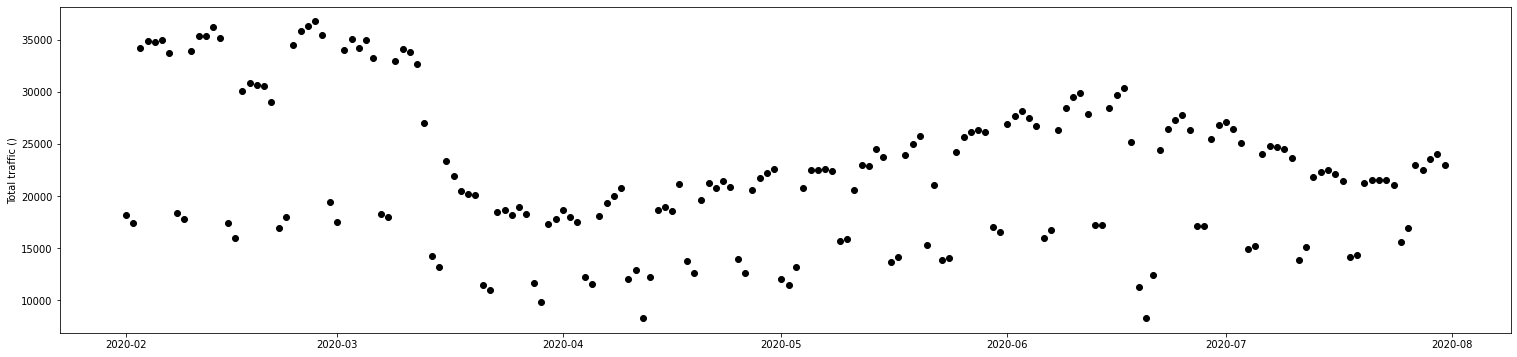

Measure point: 155, Location: st170_Kulosaari


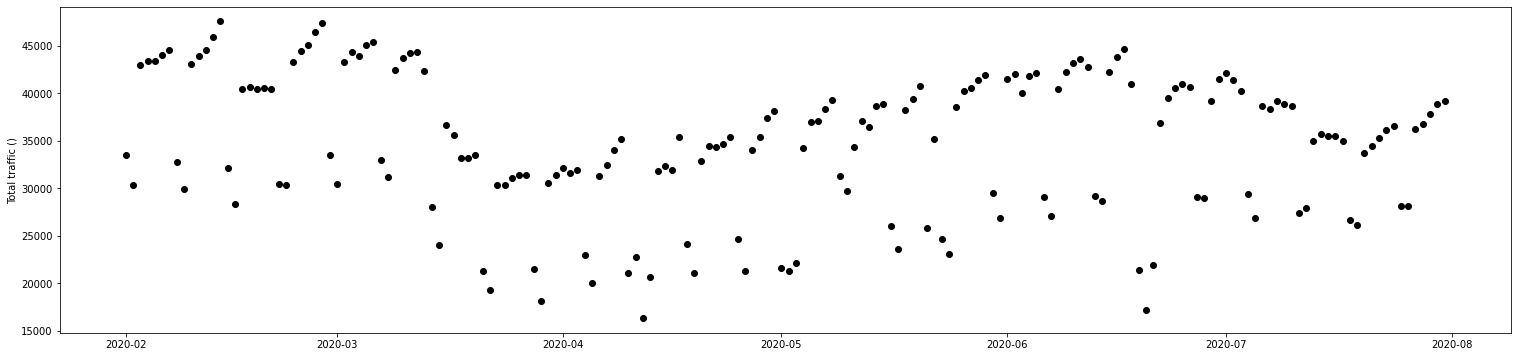

Measure point: 197, Location: st100_Kivihaan_tunneli


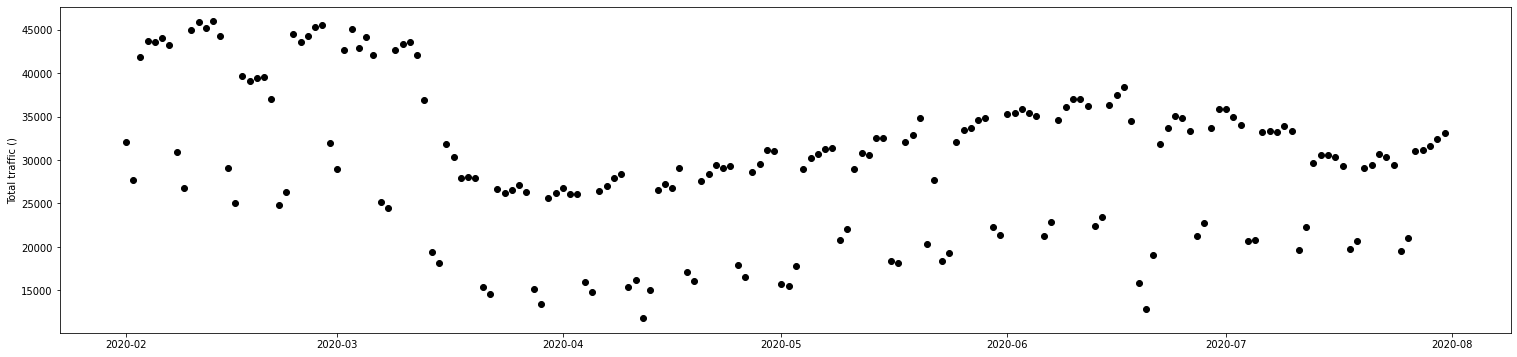

Measure point: 235, Location: vt1_Turku_Kupittaa


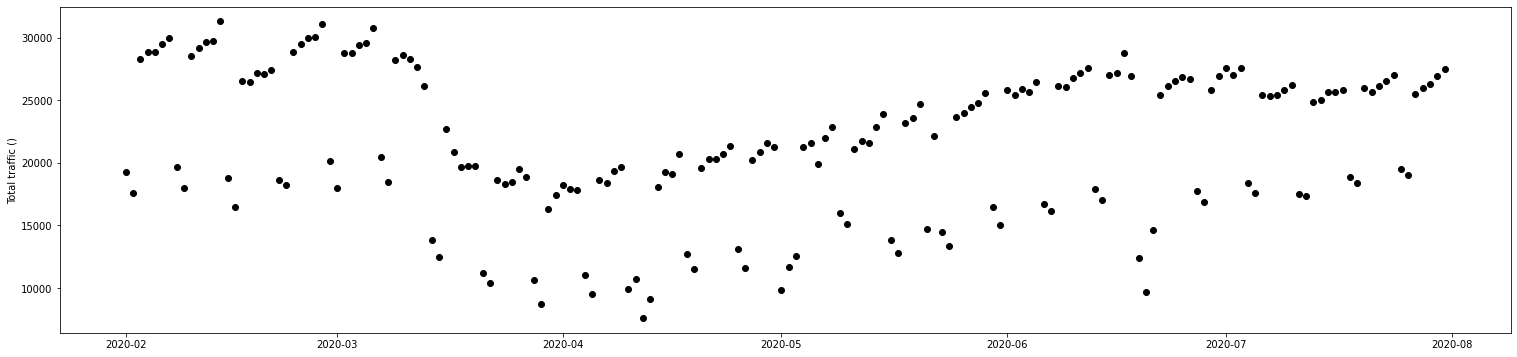

Measure point: 457, Location: vt12_Tre_Petsamo


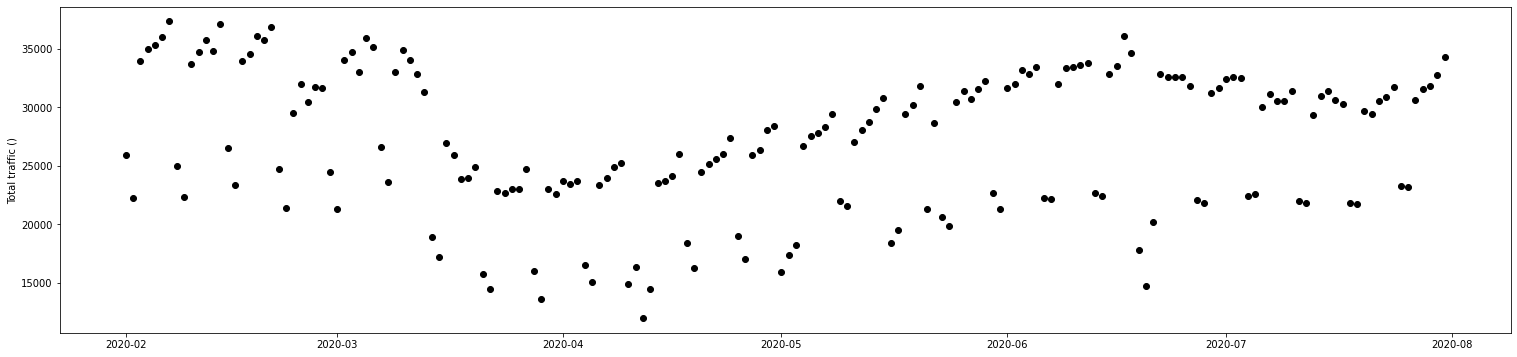

In [6]:
print('3 locations in Uusimaa, 1 in Turku and 1 in Tampere will be plotted next. ')
print()
print()


# Date interval is for each measure point the same
date_interval = df_vayla_traffic.loc[(df_vayla_traffic['Measure point'] == measure_points_plotted[0]), 
                    'Date'].tolist()

# Loop over measure points to be plotted
for i in range(len(measure_points_plotted)):
    
    # Current measure points and locations
    current_measure_point = measure_points_plotted[i]
    current_location = corresponding_locations[i]
    print('\033[1m' + 'Measure point: ' + str(current_measure_point) + ', Location: ' + current_location)

    # Total traffic of the current measure point
    current_total_traffic = df_vayla_traffic.loc[(df_vayla_traffic['Measure point'] == current_measure_point),
                    'Total traffic'].tolist()
    
    # Define the figure
    fig, host = plt.subplots(figsize=(26, 6))

    # Plot the traffic, infected and death data
    p1, = host.plot(date_interval, current_total_traffic, marker = 'o',
                    linestyle='', color = "black", label="Total traffic ()" )

    # Define the text for y-axis
    host.set_ylabel("Total traffic ()")

    # Make little spikes for different y-axis
    host.tick_params(axis='y', colors=p1.get_color())
    host.tick_params(axis='x')
        
    plt.show()